## 1. Carga de Datos

1.1 – Cargar playlists

In [1]:
import json, pandas as pd
from pathlib import Path

# root = Path(__file__).resolve().parents[1]   # carpeta proyecto
root = Path().resolve()
with open(root/'data/challenge_set.json', 'r', encoding='utf-8') as f:
    playlists_raw = json.load(f)

# Normalizar: una fila por playlist
playlists_df = pd.json_normalize(
    playlists_raw,
    meta=['pid', 'name', 'num_tracks', 'num_holdouts', 'num_samples']
)

# Convierte la lista 'tracks' en una sola columna de listas
print(playlists_df.columns.tolist())


['date', 'version', 'playlists', 'name', 'description']


1.2 – Eliminar playlists vacías


In [2]:
playlists = playlists_raw['playlists']  # Extraer la lista de playlists
playlists_df = pd.json_normalize(
    playlists,
    meta=['pid', 'name', 'num_tracks', 'num_holdouts', 'num_samples']
)
playlists_df = playlists_df[playlists_df['num_samples'] > 0].copy()
print(f"Playlists después del filtro: {len(playlists_df)}")

Playlists después del filtro: 9000


1.3 – Cargar features de AcousticBrainz

In [3]:
# 02_load_acoustic_flat_reduce.py
import orjson, pandas as pd
from pathlib import Path

# root = Path(__file__).resolve().parents[1]

# ---------- 1. Leer JSON ----------
with open(root / 'data/acousticbrainz_data_updated_clean.json', 'rb') as f:
    feat_dict = orjson.loads(f.read())          # {track_id: {...}}

# ---------- 2. Configuración ----------
# Categorías cuyo dict "all" queremos desplegar (mantendremos TODAS sus probabilidades)
CAT_WITH_ALL = {
    "genre_dortmund",
    "genre_electronic",
    "genre_rosamerica",
    "genre_tzanetakis",
    "ismir04_rhythm",
    "moods_mirex",
    "danceability", "gender",
    "mood_acoustic", "mood_aggressive", "mood_electronic",
    "mood_happy", "mood_party", "mood_relaxed", "mood_sad",
    "timbre", "tonal_atonal", "voice_instrumental",
}

# # Categorías de las que solo queremos *_value y *_prob (nada más)
# CATS_KEEP_VAL_PROB = [
#     "danceability", "gender",
#     "mood_acoustic", "mood_aggressive", "mood_electronic",
#     "mood_happy", "mood_party", "mood_relaxed", "mood_sad",
#     "timbre", "tonal_atonal", "voice_instrumental",
# ]

# ---------- 3. Aplanar ----------
rows = []
for track_id, info in feat_dict.items():
    base = {k: v for k, v in info.items() if k != "highlevel"}  # bpm, energy…

    hl = info.get("highlevel", {})
    for cat, cat_dict in hl.items():
        # Siempre guarda value y prob (los filtraremos luego)
        base[f"{cat}_value"] = cat_dict.get("value")
        base[f"{cat}_prob"]  = cat_dict.get("probability")

        # Si está en la lista de "quiero todas las probs", añade dict all
        if cat in CAT_WITH_ALL:
            for subk, p in cat_dict.get("all", {}).items():
                base[f"{cat}_{subk}"] = p

    base["track_id"] = track_id
    rows.append(base)

tracks_feat_df = pd.DataFrame(rows)

# # ---------- 4. Reducir columnas ----------
# value_cols = [f"{c}_value" for c in CATS_KEEP_VAL_PROB]
# prob_cols  = [f"{c}_prob"  for c in CATS_KEEP_VAL_PROB]

other_cols = [
    col for col in tracks_feat_df.columns
    if not (col.endswith("_value") or col.endswith("_prob"))
]

# desired_cols = other_cols + value_cols + prob_cols
desired_cols = other_cols 
df_reduced = tracks_feat_df[desired_cols].copy()

# ---------- 5. Optimizar memoria ----------
float_cols = df_reduced.select_dtypes("float64").columns
df_reduced[float_cols] = df_reduced[float_cols].astype("float32")

print("Columnas originales:", len(tracks_feat_df.columns))
print("Columnas tras reducir:", len(df_reduced.columns))
print("Tamaño en memoria (MB):",
      df_reduced.memory_usage(deep=True).sum() / 1e6)

# ---------- 6. Guardar ----------
out = root / 'data' / 'processed'
out.mkdir(exist_ok=True, parents=True)

df_reduced.to_parquet(
    out / 'tracks_feat_flat.parquet',
    engine='pyarrow',
    compression='snappy',
    index=False
)
df_reduced.head()

Columnas originales: 120
Columnas tras reducir: 83
Tamaño en memoria (MB): 34.444235


,mbid,genre_mb,bpm,energy,danceability_ll,loudness,rating_votes,danceability_danceable,danceability_not_danceable,gender_female,...,timbre_dark,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_instrumental,voice_instrumental_voice,track_id,top_genre_hl,danceability_hl,mood_happy,acousticness
0,302944eb-7cb7-4045-b99c-c440c362718f,None,125.898476,4.910242,1.067135,0.816509,None,0.941562,0.058438,0.838504,...,0.999070,0.990423,0.009577,0.082268,0.917732,66U0ASk1VHZsqIkpMjKX3B,NaN,NaN,NaN,NaN
1,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,None,128.037704,4.296187,0.937844,0.785428,None,0.492779,0.507221,0.409892,...,0.402009,0.913942,0.086058,0.751203,0.248797,5MhsZlmKJG6X5kTHkdwC4B,NaN,NaN,NaN,NaN
2,4b789101-f2f6-45f9-8a20-16705010a7a0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0GZoB8h0kqXn7XFm4Sj06k,NaN,NaN,NaN,NaN
3,172cc9c9-3725-452e-81fa-b26f7c3c6c31,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,35kahykNu00FPysz3C2euR,NaN,NaN,NaN,NaN
4,0c14d62c-01f2-4b44-ab8d-a65c97405fde,None,99.882507,4.392409,1.130975,0.920415,None,0.999133,0.000867,0.721461,...,0.791275,0.986704,0.013296,0.011536,0.988464,3G6hD9B2ZHOsgf4WfNu7X1,NaN,NaN,NaN,NaN


1.4 – Expandir playlists a nivel canción

In [4]:

import pandas as pd, ast
from pathlib import Path

# root = Path(__file__).resolve().parents[1]
# playlists_df = pd.read_pickle(root/'data/playlists_df.pkl')

# ‘tracks’ es una lista de dicts → explode
playlists_df['tracks'] = playlists_df['tracks'].apply(lambda x: x)  # ya es lista
pl_tracks = playlists_df.explode('tracks', ignore_index=True)

# Cada dict track → columnas planas
tracks_cols = pd.json_normalize(pl_tracks['tracks'])
playlist_track_df = pd.concat(
    [pl_tracks[['pid','name']], tracks_cols], axis=1
)


1.5 – Unir features

In [5]:
# 1️⃣  Extrae el track-id puro de la URI dentro de las playlists
playlist_track_df['track_id'] = (
    playlist_track_df['track_uri']
      .str.split(':')
      .str[-1]             # último fragmento después del segundo ':'
)

# -------------------------------------------
# 2. Features-level  → asegúrate de tener track_id
#    (tras el script de aplanado, la columna YA se llama track_id)
# -------------------------------------------
# Si viniera como 'track_uri', la renombramos:
# tracks_feat_df.rename(columns={'track_uri': 'track_id'}, inplace=True)

# -------------------------------------------
# 3. Merge por track_id
# -------------------------------------------
playlist_track_full = playlist_track_df.merge(
    tracks_feat_df,
    on='track_id',
    how='left',
    validate='m:1'      # opcional: verifica que cada track_id exista máximo una vez en tracks_feat_df
)

# -------------------------------------------
# 4. Chequeo rápido
# -------------------------------------------
print(
    playlist_track_full[['track_uri', 'track_id', 'loudness']].head()
)
print("NaN en loudness:",
      playlist_track_full['loudness'].isna().mean()*100, "%")

                              track_uri                track_id  loudness
0  spotify:track:66U0ASk1VHZsqIkpMjKX3B  66U0ASk1VHZsqIkpMjKX3B  0.816509
1  spotify:track:5MhsZlmKJG6X5kTHkdwC4B  5MhsZlmKJG6X5kTHkdwC4B  0.785428
2  spotify:track:0GZoB8h0kqXn7XFm4Sj06k  0GZoB8h0kqXn7XFm4Sj06k       NaN
3  spotify:track:35kahykNu00FPysz3C2euR  35kahykNu00FPysz3C2euR       NaN
4  spotify:track:3G6hD9B2ZHOsgf4WfNu7X1  3G6hD9B2ZHOsgf4WfNu7X1  0.920415
NaN en loudness: 55.71103202846975 %


— Verificar % valor_faltante para features faltantes; tomar nota para imputación.

In [6]:
import pandas as pd
from pathlib import Path

# df = pd.read_parquet('data/processed/playlist_track_full.parquet')
df = playlist_track_full

# % de valores faltantes por columna
na_pct = df.isna().mean() * 100
na_pct = na_pct.sort_values(ascending=False)

pd.set_option('display.max_columns', None)      # Muestra todas las columnas
pd.set_option('display.width', None)            # Ajusta el ancho de impresión
pd.set_option('display.expand_frame_repr', False)  # No dividir filas en varias líneas


# Muestra las 20 peores columnas
# print(na_pct.head(20))
print(na_pct)

# (Opcional) Guarda el resumen
na_pct.to_csv('reports/missing_value_percentages.csv')

# Guarda el dataframe en parquet
playlist_track_full.to_parquet("data/processed/playlist_track_full.parquet")



genre_mb        100.0
rating_value    100.0
acousticness    100.0
mood_happy      100.0
rating_votes    100.0
                ...  
artist_uri        0.0
track_name        0.0
album_uri         0.0
duration_ms       0.0
track_id          0.0
Length: 130, dtype: float64


1.6 - Guardado de clean Dataframes

In [7]:
import pandas as pd
from pathlib import Path
import numpy as np # Importante para np.nan

# ------------------------------------------------------------------
# Asumimos que ya cargaste playlist_track_full  (merge completo)
# ------------------------------------------------------------------
df = playlist_track_full.copy()

# ==============================================================
# 1)  ELIMINAR COLUMNAS 100 % NaN
# ==============================================================
na_pct = df.isna().mean()
cols_drop = na_pct[na_pct == 1.0].index
df_clean = df.drop(columns=cols_drop)

print(f"Columnas eliminadas por 100 % NaN: {len(cols_drop)}")
# ---------------------------------------------------------------

# ==============================================================
# 2)  DataFrame SOLO con canciones cuyo registro está COMPLETO
#     (sin NaN en ningún atributo numérico que nos interesa)
# ==============================================================
num_cols = df_clean.select_dtypes(include=["number"]).columns
df_complete = df_clean.dropna(subset=num_cols).reset_index(drop=True)

print("Canciones con datos completos:", df_complete.shape)

# ==============================================================
# 3)  DataFrame con IMPUTACIÓN por media (NUMÉRICA)
# ==============================================================
df_imputed = df_clean.copy()

# ---- 3.1  Calculamos medias por playlist y rellenamos ----------
df_imputed[num_cols] = (
    df_imputed
      .groupby("pid")[num_cols]
      .transform(lambda col: col.fillna(col.mean()))
)

# ---- 3.2  Fallback con mediana global para NaN restantes ------
df_imputed[num_cols] = df_imputed[num_cols].fillna(df_imputed[num_cols].median())

# ---- 3.3  Bandera de imputación --------------------------------
was_na_numeric = df_clean[num_cols].isna().any(axis=1)
df_imputed["was_imputed"] = was_na_numeric.astype(int)

print("Filas imputadas (numérico):", df_imputed['was_imputed'].sum())

# =================================================================
# !! NUEVO PASO 3.5 !! IMPUTACIÓN DE COLUMNAS *_value DESDE EL DATAFRAME
# =================================================================
print("\nIniciando imputación de columnas categóricas ('*_value')...")

# 1. Identificar todas las columnas que terminan en '_value'
all_value_cols = [col for col in df_imputed.columns if col.endswith('_value')]

# 2. Iterar sobre cada una de estas columnas para imputar sus NaNs
for value_col in all_value_cols:
    # Continuar solo si hay valores nulos que imputar en esta columna
    if not df_imputed[value_col].isnull().any():
        continue

    # 3. Extraer el prefijo base de la categoría. Ej: 'genre_rosamerica'
    base_name = value_col.replace('_value', '')
    
    # 4. Encontrar las columnas de probabilidad asociadas en el DataFrame.
    #    Ej: ['genre_rosamerica_cla', 'genre_rosamerica_dan', ...]
     # Ahora solo se consideran columnas de probabilidad reales (valores <= 1.0)
    prob_cols = [
        c for c in df_imputed.columns
        if (
            c.startswith(base_name + '_') and
            not c.endswith(('_value', '_prob')) and
            # Condición clave: Excluye métricas que no son probabilidades
            (df_imputed[c].max() <= 1.0)
        )
    ]

    # Si no se encontraron columnas de probabilidad, no podemos imputar.
    if not prob_cols:
        print(f"  - No se encontraron columnas de probabilidad para '{value_col}'. Se omite.")
        continue
    
    print(f"  - Imputando NaNs en '{value_col}'...")

    # 5. Para cada fila, encontrar el nombre de la columna con la probabilidad máxima
    #    idxmax(axis=1) devuelve el índice (nombre de la columna) del valor máximo por fila.
    max_prob_col_series = df_imputed[prob_cols].idxmax(axis=1)

    # 6. Extraer el sufijo de la columna (el valor real que queremos imputar)
    #    Ej: de 'genre_rosamerica_rhy' extraemos 'rhy'
    imputed_values = max_prob_col_series.str.split('_').str[-1]
    
    # 7. Rellenar los NaNs en la columna '_value' con los valores derivados.
    #    .fillna() es inteligente y solo llenará los NaNs, usando el índice para alinear.
    df_imputed[value_col].fillna(imputed_values, inplace=True)

print("Imputación categórica completada.")

# ==============================================================
# 4)  (Opcional) Guardar resultados
# ==============================================================
print("\nGuardando archivos procesados...")
out = Path("data/processed")
out.mkdir(parents=True, exist_ok=True)

df_complete.to_parquet(out / "playlist_tracks_complete.parquet", compression="snappy")
df_imputed.to_parquet(out / "playlist_tracks_imputed.parquet",  compression="snappy")

print("¡Proceso finalizado!")

Columnas eliminadas por 100 % NaN: 7
Canciones con datos completos: (124096, 123)
Filas imputadas (numérico): 156904

Iniciando imputación de columnas categóricas ('*_value')...
  - Imputando NaNs en 'danceability_value'...
  - Imputando NaNs en 'gender_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)
/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

  - Imputando NaNs en 'genre_dortmund_value'...
  - Imputando NaNs en 'genre_electronic_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)
/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

  - Imputando NaNs en 'genre_rosamerica_value'...
  - Imputando NaNs en 'genre_tzanetakis_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)
/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

  - Imputando NaNs en 'ismir04_rhythm_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_acoustic_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_aggressive_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_electronic_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_happy_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_party_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_relaxed_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'mood_sad_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'moods_mirex_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'timbre_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'tonal_atonal_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


  - Imputando NaNs en 'voice_instrumental_value'...


/tmp/ipykernel_998056/286090689.py:97: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[value_col].fillna(imputed_values, inplace=True)


Imputación categórica completada.

Guardando archivos procesados...
¡Proceso finalizado!


In [8]:
df_complete.head()

,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,danceability_danceable,danceability_not_danceable,gender_value,gender_prob,gender_female,gender_male,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_value,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_value,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_value,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_value,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_value,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_value,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_value,moods_mirex_prob,moods_mirex_Cluster1,moods_mirex_Cluster2,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_value,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_value,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_value,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,0.941562,0.058438,female,0.838504,0.838504,0.161496,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,0.072418,0.927582,not_aggressive,0.660399,3.396006e-01,0.660399,electronic,0.905014,0.905014,0.094986,not_happy,0.967353,0.032647,0.967353,party,0.660808,0.339192,0.660808,relaxed,0.927280,0.072720,0.927280,not_sad,0.527017,0.527017,0.472983,Cluster4,0.253382,0.143356,0.238793,0.139652,0.253382,0.224816,dark,0.999070,0.000930,0.999070,atonal,0.990423,0.990423,0.009577,voice,0.917732,0.082268,0.917732
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,0.492779,0.507221,male,0.590108,0.409892,0.590108,electronic,0.991147,

In [9]:
df_imputed.head()

,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,danceability_danceable,danceability_not_danceable,gender_value,gender_prob,gender_female,gender_male,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_value,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_value,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_value,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_value,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_value,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_value,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_value,moods_mirex_prob,moods_mirex_Cluster1,moods_mirex_Cluster2,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_value,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_value,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_value,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice,was_imputed
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,0.941562,0.058438,female,0.838504,0.838504,0.161496,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,0.072418,0.927582,not_aggressive,0.660399,3.396006e-01,0.660399,electronic,0.905014,0.905014,0.094986,not_happy,0.967353,0.032647,0.967353,party,0.660808,0.339192,0.660808,relaxed,0.927280,0.072720,0.927280,not_sad,0.527017,0.527017,0.472983,Cluster4,0.253382,0.143356,0.238793,0.139652,0.253382,0.224816,dark,0.999070,0.000930,0.999070,atonal,0.990423,0.990423,0.009577,voice,0.917732,0.082268,0.917732,0
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,0.492779,0.507221,male,0.590108,0.409892,0.590108,electr

## 2. Analisis Exploratorio (EDA)

2.1. Dimensiones y tipos de variables

In [10]:
# Dimensiones y tipos de variables
print("Shape:", df_imputed.shape)
print("\nTipos de variables:")
print(df_imputed.dtypes.value_counts())
print("\nPrimeras filas:")
display(df_imputed.head())

Shape: (281000, 124)

Tipos de variables:
float64    93
object     27
int64       4
Name: count, dtype: int64

Primeras filas:


,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,danceability_danceable,danceability_not_danceable,gender_value,gender_prob,gender_female,gender_male,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_value,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_value,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_value,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_value,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_value,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_value,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_value,moods_mirex_prob,moods_mirex_Cluster1,moods_mirex_Cluster2,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_value,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_value,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_value,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice,was_imputed
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,0.941562,0.058438,female,0.838504,0.838504,0.161496,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,0.072418,0.927582,not_aggressive,0.660399,3.396006e-01,0.660399,electronic,0.905014,0.905014,0.094986,not_happy,0.967353,0.032647,0.967353,party,0.660808,0.339192,0.660808,relaxed,0.927280,0.072720,0.927280,not_sad,0.527017,0.527017,0.472983,Cluster4,0.253382,0.143356,0.238793,0.139652,0.253382,0.224816,dark,0.999070,0.000930,0.999070,atonal,0.990423,0.990423,0.009577,voice,0.917732,0.082268,0.917732,0
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,0.492779,0.507221,male,0.590108,0.409892,0.590108,electr

2.2. Estadísticas descriptivas de variables numéricas


In [11]:
# Estadísticas descriptivas de variables numéricas
display(df_imputed.describe())

,pid,pos,duration_ms,bpm,energy,danceability_ll,loudness,danceability_prob,danceability_danceable,danceability_not_danceable,gender_prob,gender_female,gender_male,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_prob,moods_mirex_Cluster1,moods_mirex_Cluster2,moods_mirex_Cluster3,moods_mirex_Cluster4,moods_mirex_Cluster5,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice,was_imputed
count,2.810000e+05,281000.000000,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,281000.000000,281000.000000,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,281000.000000,281000.000000,2.810000e+05,281000.000000,281000.000000,2.810000e+05,281000.000000
mean,1.024973e+06,58.972694,2.326017e+05,121.648016,4.001260,1.176433,0.819411,0.890697,6.777642e-01,3.222358e-01,0.814700,5.359731e-01,0.464027,0.848977,4.403417e-02,2.221440e-02,0.830976,4.573260e-02,3.132902e-03,1.118040e-02,6.952844e-03,1.120747e-02,2.443124e-02,0.598965,0.412829,0.036282,0.212260,0.027965,0.310176,0.604076,3.768068e-02,1.001066e-01,1.604083e-01,4.360019e-02,2.500258e-01,2.334272e-01,0.163552,9.223251e-03,0.338930,6.001888e-02,3.608099e-02,9.110077e-02,6.791881e-02,1.429424e-01,3.284646e-01,4.647378e-02,6.582699e-02,6.120732e-02,9.990177e-02,0.563373,3.496572e-01,6.802993e-02,1.629131e-02,4.242977e-02,4.558653e-02,2.278291e-02,5.690157e-02,1.676377e-01,2.128005e-01,1.692709e

2.3. Distribución de longitud de playlists


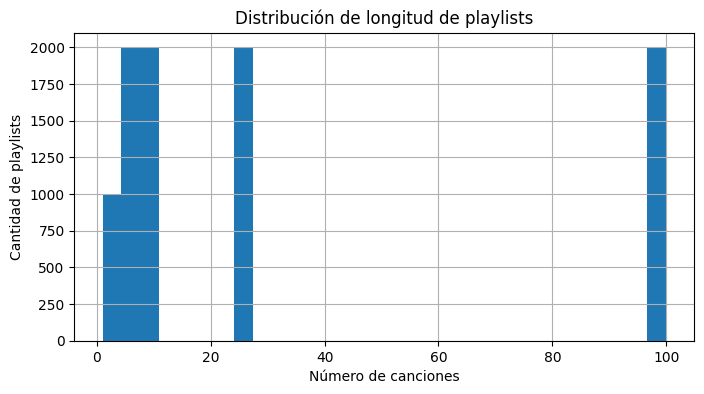

Media: 31.22222222222222 Máx: 100 Min: 1


In [12]:
# Distribución de longitud de playlists
import matplotlib.pyplot as plt
playlist_lengths = df_imputed.groupby('pid').size()
plt.figure(figsize=(8,4))
playlist_lengths.hist(bins=30)
plt.title("Distribución de longitud de playlists")
plt.xlabel("Número de canciones")
plt.ylabel("Cantidad de playlists")
plt.show()
print("Media:", playlist_lengths.mean(), "Máx:", playlist_lengths.max(), "Min:", playlist_lengths.min())

2.4. Análisis de géneros y moods


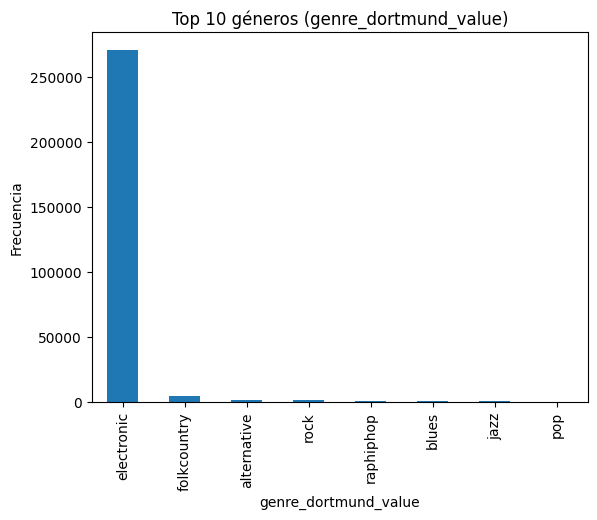

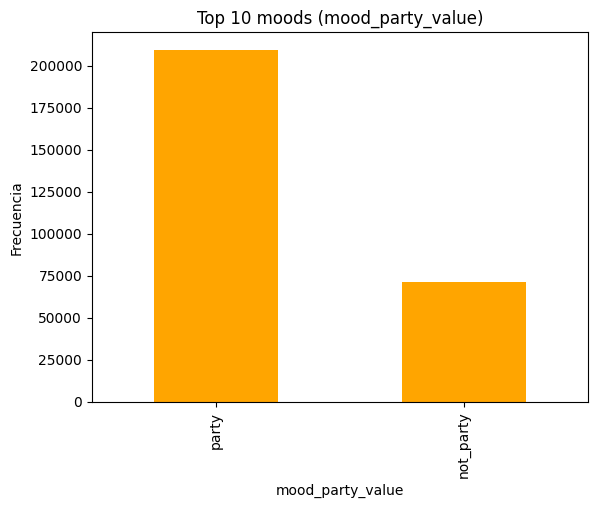

In [ ]:
# Análisis de géneros y moods
top_genres_dortmund = df_imputed['genre_dortmund_value'].value_counts().head(10)
top_genres_dortmund.plot(kind='bar')
plt.title("Top 10 géneros (genre_dortmund_value)")
plt.ylabel("Frecuencia")
plt.show()

top_genres_rosamerica = df_imputed['genre_rosamerica_value'].value_counts().head(10)
top_genres_rosamerica.plot(kind='bar', color='green')
plt.title("Top 10 géneros (genre_rosamerica_value)")
plt.ylabel("Frecuencia")
plt.show()

top_genres_electronic = 


top_moods = df_imputed['mood_party_value'].value_counts().head(10)
top_moods.plot(kind='bar', color='orange')
plt.title("Top 10 moods (mood_party_value)")
plt.ylabel("Frecuencia")
plt.show()

2.5. Correlaciones numéricas


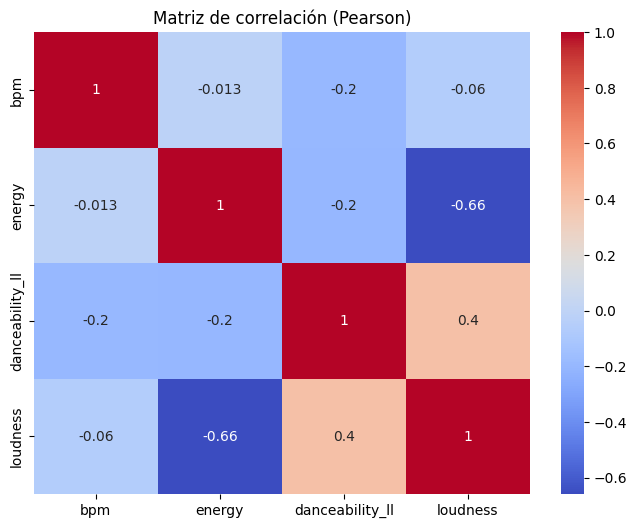

In [14]:
# Correlaciones numéricas
import seaborn as sns
num_cols = ['bpm', 'energy', 'danceability_ll', 'loudness']  # Ajusta según tus columnas
corr = df_imputed[num_cols].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación (Pearson)")
plt.show()

2.6. Outliers numéricos


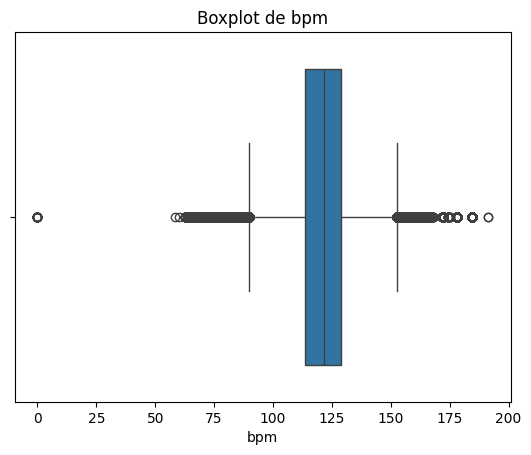

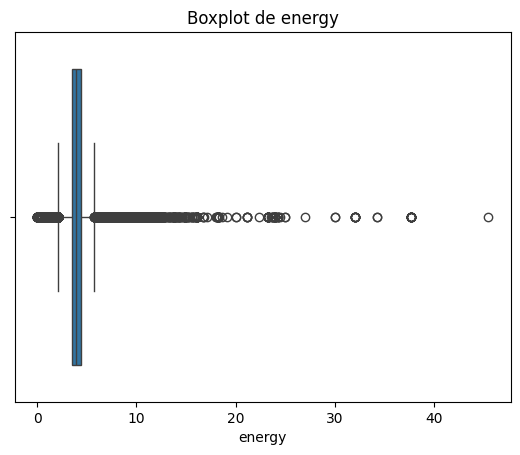

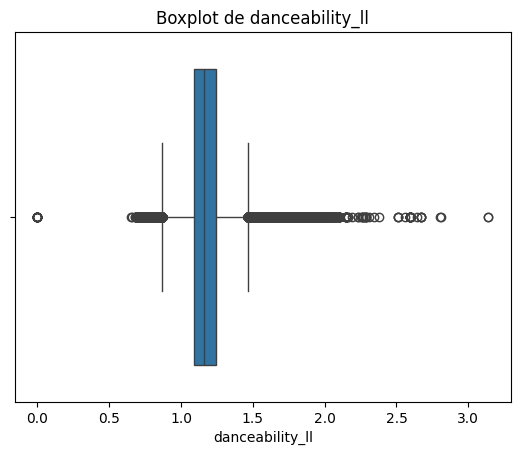

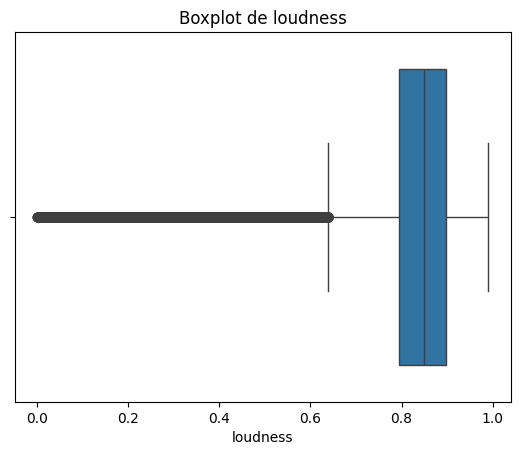

In [15]:
# Outliers numéricos con boxplots
for col in ['bpm', 'energy', 'danceability_ll', 'loudness']:
    plt.figure()
    sns.boxplot(x=df_imputed[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

2.7. Valores faltantes


name                               5.338078
mbid                               0.033096
pos                                0.000000
pid                                0.000000
artist_name                        0.000000
                                     ...   
voice_instrumental_value           0.000000
voice_instrumental_prob            0.000000
voice_instrumental_instrumental    0.000000
voice_instrumental_voice           0.000000
was_imputed                        0.000000
Length: 124, dtype: float64

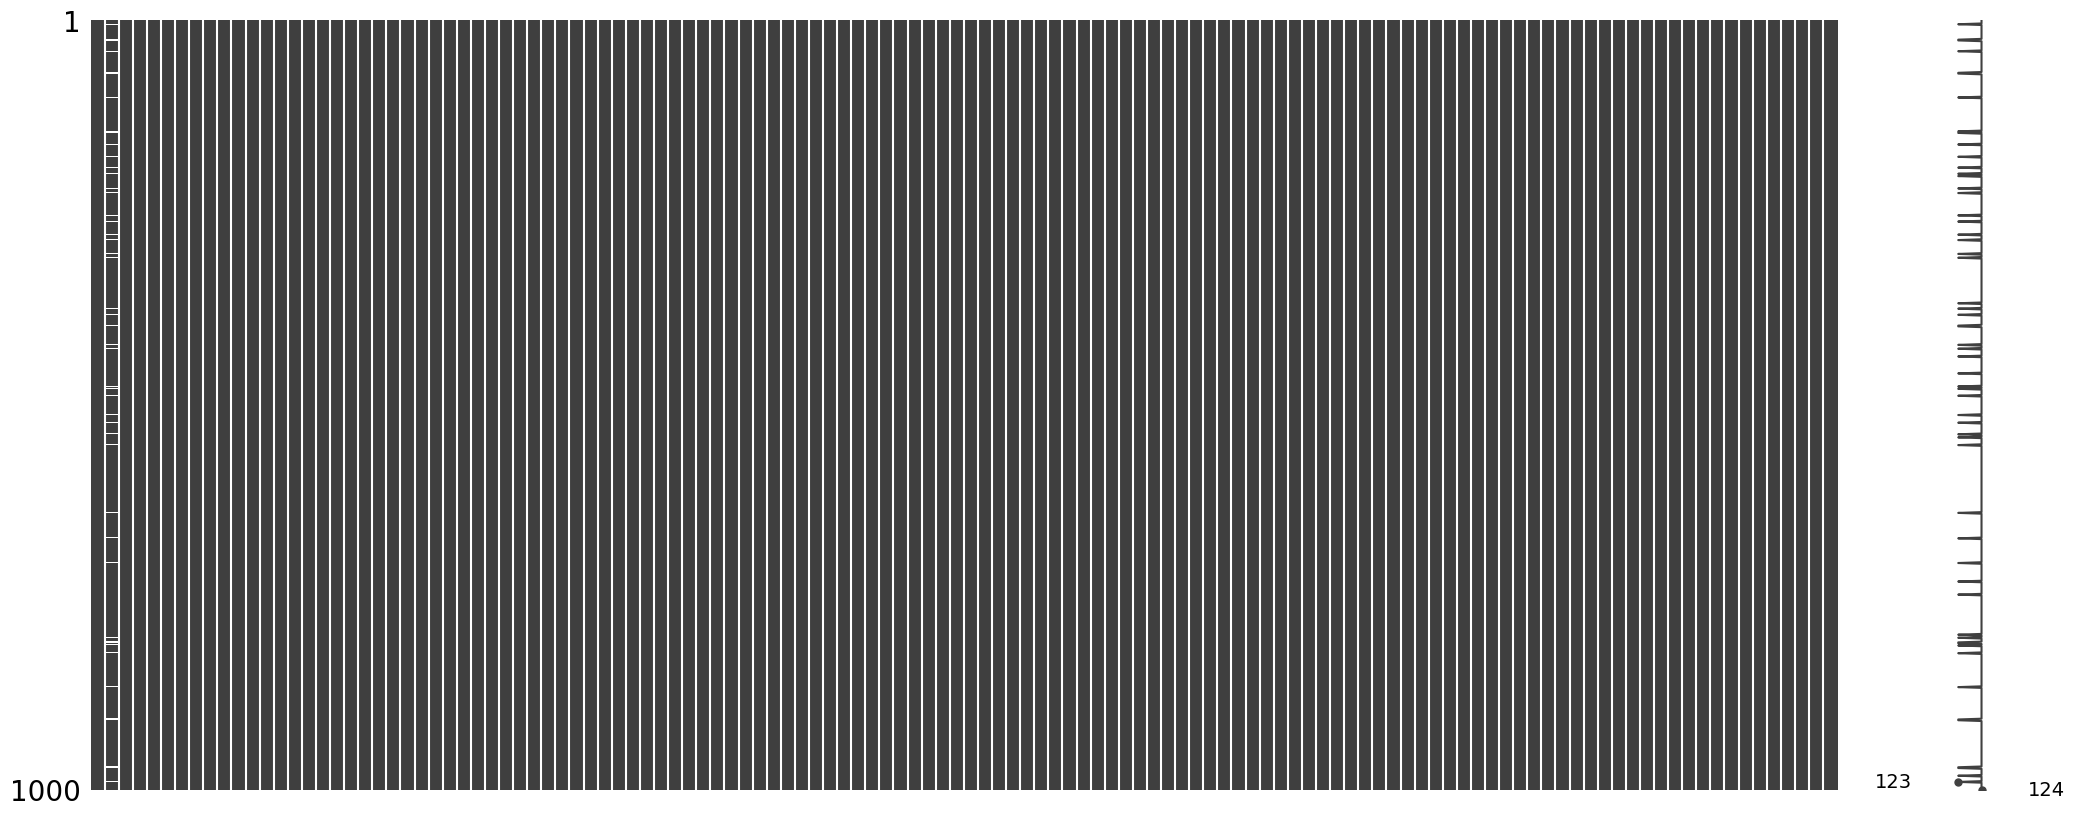

In [16]:
# Porcentaje de valores faltantes por columna
na_pct = df_imputed.isna().mean() * 100
na_pct = na_pct.sort_values(ascending=False)
display(na_pct)

# Visualización rápida (opcional)
import missingno as msno
msno.matrix(df_imputed.sample(1000, random_state=1))  # Muestra 1000 filas aleatorias
plt.show()

2.8. Canciones y artistas más frecuentes


In [17]:
# Canciones más repetidas
top_tracks = df_imputed['track_name'].value_counts().head(10)
print("Canciones más repetidas:")
display(top_tracks)

# Artistas más frecuentes
top_artists = df_imputed['artist_name'].value_counts().head(10)
print("Artistas más frecuentes:")
display(top_artists)

Canciones más repetidas:


track_name
Closer                         335
Roses                          241
Ride                           229
Broccoli (feat. Lil Yachty)    226
Ignition - Remix               222
Gold Digger                    215
Forever                        213
No Role Modelz                 211
Let Me Love You                203
HUMBLE.                        202
Name: count, dtype: int64

Artistas más frecuentes:


artist_name
Drake             4877
Kanye West        2592
Kendrick Lamar    1902
Rihanna           1734
The Weeknd        1644
Eminem            1494
Luke Bryan        1486
J. Cole           1472
Chris Brown       1418
Future            1308
Name: count, dtype: int64

2.9. Diversidad de géneros/artistas por playlist


In [18]:
# Diversidad de géneros/artistas por playlist
diversity = df_imputed.groupby('pid').agg({
    'genre_dortmund_value': pd.Series.nunique,
    'artist_name': pd.Series.nunique
}).rename(columns={'genre_dortmund_value': 'n_genres', 'artist_name': 'n_artists'})
display(diversity.describe())

,n_genres,n_artists
count,9000.000000,9000.000000
mean,1.593333,18.972222
std,0.954784,22.524625
min,1.000000,1.000000
25%,1.000000,4.000000
50%,1.000000,9.000000
75%,2.000000,23.000000
max,6.000000,100.000000


2.10. Pairplot de variables numéricas


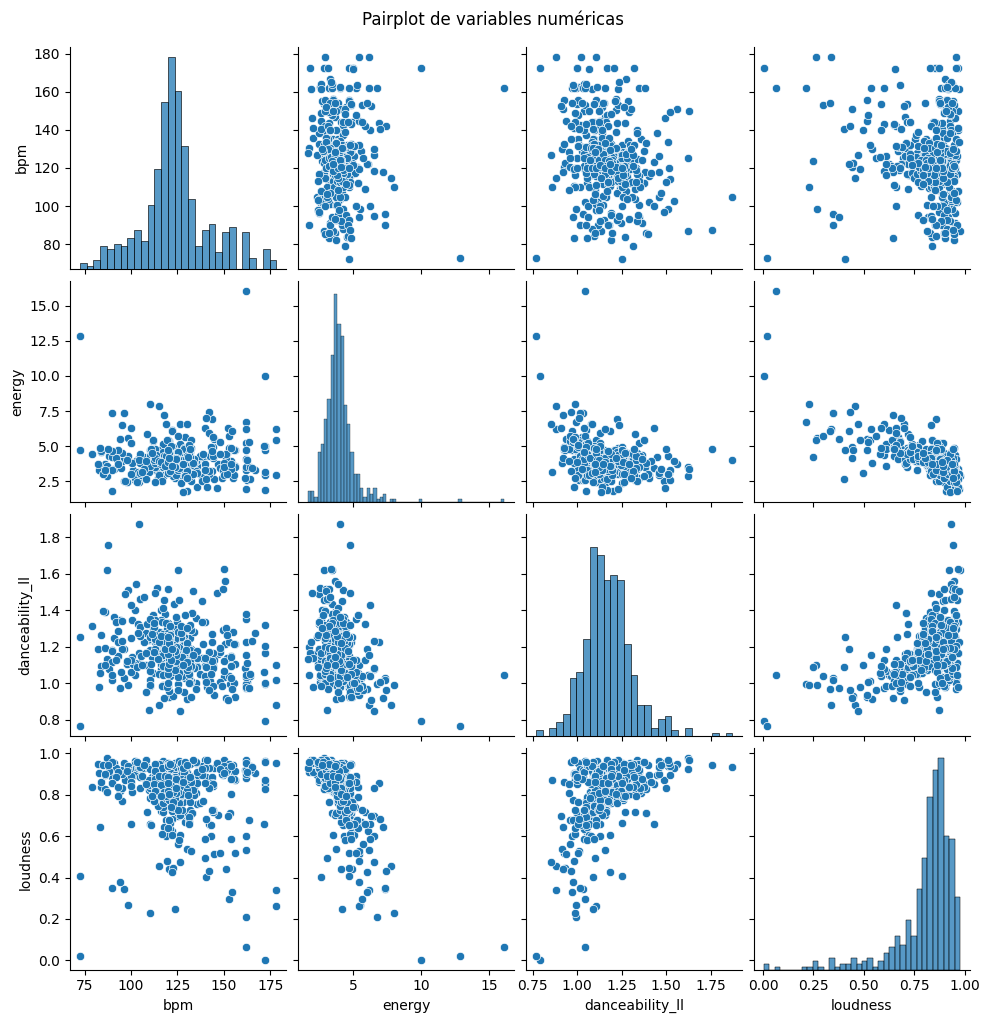

In [19]:
# Pairplot de variables numéricas
sns.pairplot(df_imputed[num_cols].dropna().sample(500, random_state=1))  # Muestra 500 filas
plt.suptitle("Pairplot de variables numéricas", y=1.02)
plt.show()